In [1]:
import os
import torch
import torchvision
from tqdm.notebook import tqdm 
from sklearn import metrics
import numpy as np 

from dataset.nih_xnet_dataset_feb3 import get_datasets
from best_model.model10 import DesnseNet121

from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

torch.manual_seed(41)

/home/mhealth-14/anaconda3/envs/iqbal/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mhealth-14/anaconda3/envs/iqbal/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")
/home/mhealth-14/anaconda3/envs/iqbal/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Dataset and Dataloader 

In [2]:
import json
from easydict import EasyDict as edict

config = None
with open('./config/example.json') as f:
    config = edict(json.load(f))

In [3]:
dataset_train, dataset_test, _ = get_datasets()

# Model Define

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DesnseNet121(num_classes=15)
model = model.to(device)
'''
with torch.no_grad():
    class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))
'''

"\nwith torch.no_grad():\n    class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))\n"

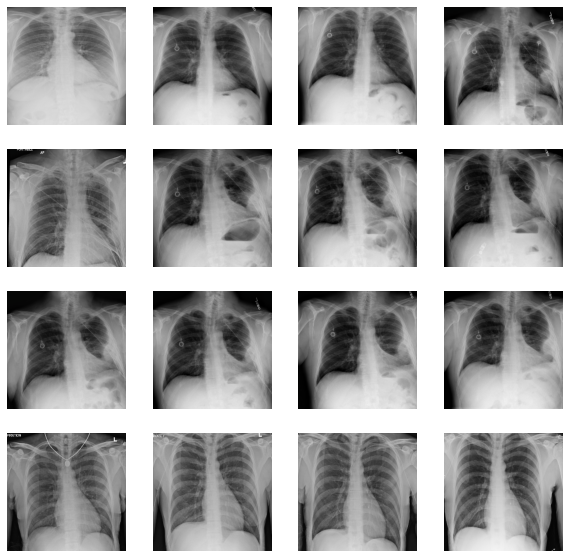

In [5]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,10))
dataiter = iter(dataset_train)

for i in range(16):
    img, _, _, _ = next(dataiter)
    img = torch.tensor(config.pixel_std).view(3, 1, 1) * img + torch.tensor(config.pixel_mean).view(3, 1, 1)
    plt.subplot(4,4,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
plt.show()

# Train-Test Functions

In [6]:
@torch.no_grad()
def test():
    model.eval()
    predlist = [[] for i in range(num_diseases)]
    truelist = [[] for i in range(num_diseases)]
    loss_list = []

    for images, abnorm_masks, lung_mask, class_label_gts in testloader:
        images = images.to(device)
        lung_mask = lung_mask.to(device)
        abnorm_masks = abnorm_masks.to(device)
        class_label_gts = class_label_gts.to(device)
        
        # class_label_preds, _ = model(images, lung_mask)
        # class_label_preds, _ = model(images)
        class_label_preds, _ = model(images, abnorm_masks, lung_mask)
        loss = loss_function(class_label_preds, class_label_gts)
        loss_list .append(loss.item())
        
        for i in range(num_diseases):
            pred = torch.sigmoid(class_label_preds[:,i]).cpu().detach().numpy()
            predlist[i] = np.append(predlist[i], pred)
            truelist[i] = np.append(truelist[i], class_label_gts[:,i].cpu().detach().numpy())
            
    predlist = np.array(predlist)
    truelist = np.array(truelist)
    loss_list = np.array(loss_list)
    loss_list = loss_list.mean()

    auclist = []
    acclist = []

    for i in range(num_diseases):
        y_pred = predlist[i]
        y_true = truelist[i]
                    
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label = 1)
        auc = metrics.auc(fpr, tpr)
        auclist.append(auc)
        acc = metrics.accuracy_score(y_true,y_pred>0.5)
        acclist.append(acc)
    auc_mean = np.array(auclist).mean()
    acc_mean = np.array(acclist).mean()
            
    model.train()


    print("Auc:",auclist,"  auc mean: ", auc_mean)
    print("Loss mean", loss_list)
    return auclist, auc_mean, acc_mean, loss_list.sum()

In [7]:

def train(global_step, test_metrices, tb_writer):
    model.train()

    acc_mean_train = 0
    acc_list_train = []
    loss_list_train = []
    acc_mean_test = test_metrices['acc_mean_test']
    auc_mean_test = test_metrices['auc_mean_test']
    compare_val_score = test_metrices['best_auc']

    pbar = tqdm(trainloader)
    for images, abnorm_masks, lung_mask, class_label_gts in pbar:
        images = images.to(device)
        lung_mask = lung_mask.to(device)
        abnorm_masks = abnorm_masks.to(device)
        class_label_gts = class_label_gts.to(device)

        model.zero_grad()
        # class_label_preds, _ = model(images, lung_mask)
        # class_label_preds, _ = model(images)
        class_label_preds, _ = model(images, abnorm_masks, lung_mask)
        loss = loss_function(class_label_preds, class_label_gts)
        loss.backward()
        optimizer.step()
        loss_list_train.append(loss.item())

        if global_step%log_step == 0:
            for name, weight in model.named_parameters():
                if weight.grad is not None:
                    tb_writer.add_histogram(name,weight, global_step//log_step)
                    tb_writer.add_histogram(f'{name}.grad', weight.grad, global_step//log_step) 

        if global_step % pbar_step == 0:
            for i in range(num_diseases):
                acc_train = metrics.accuracy_score(class_label_gts[:,i].detach().cpu().numpy(), class_label_preds[:,i].detach().cpu().numpy()>0.5)
                acc_list_train.append(acc_train)

            loss_list_train = np.array(loss_list_train)
            train_loss = loss_list_train.mean()
            acc_list_train = np.array(acc_list_train)
            acc_mean_train = acc_list_train.mean()
            acc_list_train = []
            loss_list_train = []
            lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({'loss': train_loss, 'tacc':acc_mean_train,'vacc':acc_mean_test,'mauc':compare_val_score,'step_auc':auc_mean_test,'epoch':epoch, 'lr':lr})

            tb_writer.add_scalar('Loss/Train', train_loss, global_step//pbar_step)
            tb_writer.add_scalar('Accuracy/Train', acc_mean_train, global_step//pbar_step)
            tb_writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], global_step//pbar_step)


        if global_step % log_step == 0:
            auc_list, auc_mean_test, acc_mean_test, loss_test = test()
            test_metrices['auc_mean_test'] = auc_mean_test
            test_metrices['acc_mean_test'] = acc_mean_test
            
            checkpoint = {
                    'epoch' : epoch,
                    'global_step' : global_step,
                    'model' : model,
                    'optimizer' : optimizer,
                    'test_metrices' : test_metrices
                }
            torch.save(checkpoint, 'last.ckpt')
            
            tb_writer.add_scalar('Loss/Valid', loss_test, global_step//log_step)
            tb_writer.add_scalar('Accuracy/Valid', acc_mean_test, global_step//log_step)
            tb_writer.add_scalar('AUC/Valid', auc_mean_test, global_step//log_step)

            lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({'loss-test': loss_test,'tacc':acc_mean_train,'vacc':acc_mean_test,'mauc':compare_val_score,'step_auc':auc_mean_test,'epoch':epoch, 'lr':lr})

            if auc_mean_test > compare_val_score:
                test_metrices['best_auc'] = auc_mean_test
                checkpoint = {
                    'epoch' : epoch,
                    'global_step' : global_step,
                    'model' : model,
                    'optimizer' : optimizer,
                    'test_metrices' : test_metrices
                }
                torch.save(checkpoint, 'best.ckpt')
                compare_val_score = auc_mean_test
             
        global_step += 1

    return global_step, test_metrices

# Training Parameters

In [8]:
batch_size = 16
epochs = 17
num_diseases = 14
resume = False
log_step = 4904
pbar_step = 1000

In [9]:
trainloader = torch.utils.data.DataLoader(
                    dataset_train, batch_size=batch_size,
                    shuffle=True, drop_last=True, num_workers=4)

# indices = list(range(500))
# tr_10k = torch.utils.data.Subset(dataset_test, indices)
testloader = torch.utils.data.DataLoader(
                    dataset_test, batch_size=batch_size,
                    drop_last = True, num_workers=4)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay =  0.0001)
loss_function = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

# Training Phase

In [11]:
if resume and os.path.exists('last.ckpt'): 
    checkpoint_dict = torch.load("last.ckpt")
    epoch = checkpoint_dict['epoch']
    model = checkpoint_dict['model']
    optimizer = checkpoint_dict['optimizer']
    global_step = checkpoint_dict['global_step'] + 1
    test_metrices = checkpoint_dict['test_metrices']
    model.eval()
else:
    epoch = 1
    global_step = 1
    test_metrices = {
        'acc_mean_test' : 0,
        'auc_mean_test' : 0,
        'best_auc' : 0
    }
    
print(test_metrices['best_auc'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

0


In [ ]:
writer = SummaryWriter(log_dir='./runs/model9exp1')
images, _, _, labels = next(iter(trainloader))
image_grid = torchvision.utils.make_grid(images)
writer.add_image("images",image_grid)
# writer.add_graph(model, images.to(device))

while epoch <= epochs:
    global_step, test_metrices = train(global_step, test_metrices, writer)
    if epoch % 5 == 0:
        scheduler.step()
    epoch = epoch + 1
        
writer.close()

In [ ]:
import torch
model= torch.load("best.ckpt")['model']
_, _, test_ds = get_datasets()
testloader = torch.utils.data.DataLoader(
                    test_ds, batch_size=batch_size,
                    drop_last = True, num_workers=4)
auclist, auc_mean, acc_mean, loss = test()

In [ ]:
acc_mean

In [ ]:
import torch
x = torch.load('last.ckpt')
print(x['epoch'])